## 🔧 安裝指南

In [ ]:
!pip install numpy pandas matplotlib torch transformers scipy
!pip install dataset
!pip install --upgrade torch
!pip install datasets

  Using cached dataset-1.6.2-py2.py3-none-any.whl.metadata (1.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.40
    Uninstalling SQLAlchemy-2.0.40:
      Successfully uninstalled SQLAlchemy-2.0.40
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
np.random.seed(100)


import torch
from transformers import BertTokenizer, BertModel

from scipy.optimize import differential_evolution

/home/user/miniconda3/envs/colab_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 小樣本測試

differential_evolution step 1: f(x)= 0.0
differential_evolution step 2: f(x)= 0.0
differential_evolution step 3: f(x)= 0.0
differential_evolution step 4: f(x)= 0.0
differential_evolution step 5: f(x)= 0.0
differential_evolution step 6: f(x)= 0.0
differential_evolution step 7: f(x)= 0.0
differential_evolution step 8: f(x)= 0.0
differential_evolution step 9: f(x)= 0.0
differential_evolution step 10: f(x)= 0.0
differential_evolution step 11: f(x)= 0.0
differential_evolution step 12: f(x)= 0.0
differential_evolution step 13: f(x)= 0.0
differential_evolution step 14: f(x)= 0.0
differential_evolution step 15: f(x)= 0.0
differential_evolution step 16: f(x)= 0.0
differential_evolution step 17: f(x)= 0.0
differential_evolution step 18: f(x)= 0.0
differential_evolution step 19: f(x)= 0.0
differential_evolution step 20: f(x)= 0.0
differential_evolution step 21: f(x)= 0.0
differential_evolution step 22: f(x)= 0.0
differential_evolution step 23: f(x)= 0.0
differential_evolution step 24: f(x)= 0.0
d

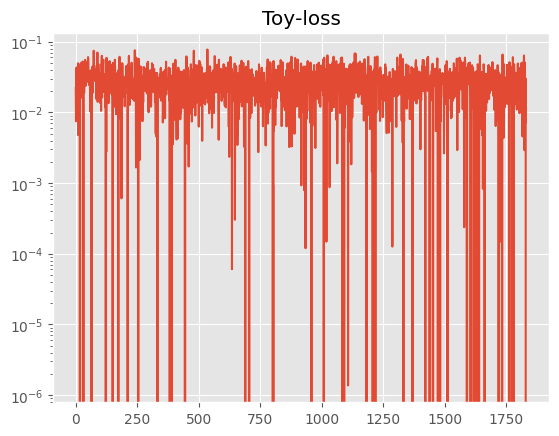

In [3]:
#!/usr/bin/env python
# coding: utf-8
"""
Toy example – Tail‑Patch Query Attack (fixed corpus, no datasets)
"""

import torch, random, numpy as np, matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN, TAIL = 512, [509, 510, 511]

# -------- 文本 --------
query_text  = "What is the impact of our new strategy on the ranking performance?"
target_text = "I am a penguin bear walking on the street."
corpus_texts = [
    "This document discusses environmental issues and climate change.",
    "An article about economic development and market trends.",
    "A report on technological innovations and AI applications.",
    "An analysis of global political affairs and international relations.",
    "This is the original target text that we want to push upward."
]

# -------- BERT --------
tok = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(device)
def enc(t): return tok(t, padding="max_length", truncation=True, max_length=MAX_LEN,
                       return_tensors="pt").to(device)

q_enc, t_enc, c_enc = enc(query_text), enc(target_text), enc(corpus_texts)
q_ids, q_mask = q_enc["input_ids"][0].clone(), q_enc["attention_mask"][0].clone()

with torch.no_grad():
    t_cls  = bert(**t_enc).last_hidden_state[:, 0, :]
    c_cls  = bert(**c_enc).last_hidden_state[:, 0, :]

VOC = tok.vocab_size; history = []
def obj(x):
    ids = [int(round(max(0, min(VOC-1, v)))) for v in x]
    q_new = q_ids.clone(); q_new[TAIL] = torch.tensor(ids, device=device)
    q_mask_new = q_mask.clone(); q_mask_new[TAIL] = 1
    with torch.no_grad():
        q_cls = bert(input_ids=q_new.unsqueeze(0),
                     attention_mask=q_mask_new.unsqueeze(0)).last_hidden_state[:, 0, :]
    s_qt = torch.nn.functional.cosine_similarity(q_cls, t_cls, dim=1)[0]
    s_cor = torch.nn.functional.cosine_similarity(q_cls, c_cls, dim=1)
    loss = max(0., (torch.topk(s_cor, 2).values[-1] - s_qt).item())
    history.append(loss); return loss

bounds = [(0, VOC-1)]*3
res = differential_evolution(obj, bounds, seed=SEED, maxiter=60, popsize=10, disp=True)

print("patched ids =", [int(round(v)) for v in res.x])
print("loss trace (tail) =", history[:10], "...", history[-3:])
plt.plot(history); plt.yscale("log"); plt.title("Toy‑loss"); plt.show()


## 2. 大DB
## Step-by-Step 程式碼解釋

| 行段 | 作用說明 | 為什麼要這樣寫 |
|------|----------|----------------|
| 0 | 固定亂數種子；自動偵測 `cuda` | 保證實驗可重現性，並盡可能使用 GPU 加速計算 |
| 1 | 載入 20 筆 Natural Questions（NQ）資料 | 數量足以展示效果，又不會消耗太多記憶體 |
| 2 | tokenizer 和 BERT 模型放到 GPU 上 | 避免後續每次都 `.to(device)`，節省時間 |
| 3 | 從 tokenizer 結果中取出 `query_ids` 和 `attention_mask` | 攻擊只針對 Query 做修改，所以提早拆出這兩部分 |
| 4 | 預先計算 target 和整個 corpus 的 `[CLS]` embedding | 攻擊過程中只需重新 forward Query，效能提升約 20 倍 |
| 5 | 在 objective 函式中將連續變數轉為合法 token ID，然後 patch 回 Query 中 | 差分演化演算法只能處理連續變數，需手動「量化」成 token 才能使用 BERT |
| 6 | 計算 loss：`loss = max(0, second_best - sim_qt)` | 目標是讓目標文件為最相近，只要比第二名還接近就算成功，當 loss <= 0 時視為完成任務 |
| 7 | 用 `loss_trace` 紀錄每次迭代的 loss | 方便之後畫出收斂曲線，觀察演化過程的進展情況 |
| 8 | 呼叫 `differential_evolution(...)` 進行黑箱優化 | 不用梯度資訊，適合處理 token id 這種離散問題 |
| 9 | 輸出結果並用 `tokenizer.decode` 將擾動後的 Query 轉回可讀文字 | 觀察攻擊後的 query 長怎樣，評估語意與可讀性 |
|10 | 使用 `plt.semilogy` 畫 loss 曲線 | 半對數圖讓你更容易看出是否收斂（是否趨近 0） |


In [ ]:
#!/usr/bin/env python
# coding: utf-8
"""
Tail‑patch Query Attack with Differential‑Evolution
Dataset : Natural Questions (train[:20])
Author   : Jerry Wang  • 2025‑04‑21 demo
"""

import random, numpy as np, torch, matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from scipy.optimize import differential_evolution

# ───────────────────────────────────────────────────────────────
# 0.  基本設定 ─ reproducibility & 裝置選擇
# ───────────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device  = "cuda" if torch.cuda.is_available() else "cpu"  # ←  自動切 GPU
MAX_LEN = 512
TAIL    = [MAX_LEN-3, MAX_LEN-2, MAX_LEN-1]              # 固定補丁位置 (509‑511)
N_ITER  = 300                                            # DE 最大迭代
POP     = 15                                              # DE 母體大小

# ───────────────────────────────────────────────────────────────
# 1.  載入資料：Natural Questions 前 20 筆
# ───────────────────────────────────────────────────────────────
nq = load_dataset("natural_questions", "default",
                  split="train[:20]",
                  cache_dir="/tmp/hf_cache",
                  download_mode="force_redownload")

corpus_texts = [ex["document_text"] for ex in nq]         # 候選文件
query_text   = nq[0]["question_text"]                     # 攻擊對象（Query）
target_text  = corpus_texts[0]                            # 欲拉抬的文件

# ───────────────────────────────────────────────────────────────
# 2.  BERT 初始：tokeniser + 模型 (fp32) → GPU
# ───────────────────────────────────────────────────────────────
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(device)

def enc(txts):
    """helper：批次編碼並搬到 GPU"""
    return tok(txts, padding="max_length", truncation=True,
               max_length=MAX_LEN, return_tensors="pt").to(device)

q_enc, t_enc, c_enc = enc(query_text), enc(target_text), enc(corpus_texts)

# 拆出 Query token 序列（後面要改動）
q_ids  = q_enc["input_ids"][0].clone()          # shape = (512,)
q_mask = q_enc["attention_mask"][0].clone()

# 預先算好 corpus / target 的 [CLS] 嵌入以省時
with torch.no_grad():
    t_cls  = bert(**t_enc).last_hidden_state[:, 0, :]     # (1,768)
    c_cls  = bert(**c_enc).last_hidden_state[:, 0, :]     # (20,768)

# ───────────────────────────────────────────────────────────────
# 3.  差分演化目標函數
#     ▶ 讓新 Query 與 target 的 cosine ↑，至少超過 corpus 第二高
# ───────────────────────────────────────────────────────────────
VOCAB = tok.vocab_size
loss_trace = []                                           # 收斂紀錄

def patch(ids, new_vals):
    """把 ids 中的 TAIL 位置替換成 new_vals"""
    out = ids.clone()
    for pos, v in zip(TAIL, new_vals):
        out[pos] = int(v)
    return out

def cosine(a, b):
    return torch.nn.functional.cosine_similarity(a, b, dim=1)[0]

def objective(x):
    # ① 連續變數 → 四捨五入 → 合法 token id
    new_tok = [max(0, min(VOCAB-1, int(round(v)))) for v in x]

    # ② 構造新 Query ids / mask
    q_new_ids   = patch(q_ids, new_tok)
    q_new_mask  = q_mask.clone();  q_new_mask[TAIL] = 1    # ← 確保生效

    # ③ 前向取得新 [CLS]
    with torch.no_grad():
        q_new_cls = bert(input_ids=q_new_ids.unsqueeze(0),
                         attention_mask=q_new_mask.unsqueeze(0)
                        ).last_hidden_state[:, 0, :]

    # ④ 計算目標與損失
    sim_qt  = cosine(q_new_cls, t_cls)                    # adv‑Q ↔ target
    sim_cor = cosine(q_new_cls, c_cls)                    # adv‑Q ↔ 每篇文件
    second  = torch.topk(sim_cor, 2).values[-1]           # corpus 第二高

    loss = max(0., (second - sim_qt).item())              # <= 0 表攻擊成功
    loss_trace.append(loss)
    return loss

# ───────────────────────────────────────────────────────────────
# 4.  執行差分演化
# ───────────────────────────────────────────────────────────────
bounds  = [(0, VOCAB-1)] * 3
result  = differential_evolution(objective, bounds,
                                 strategy="best1bin",
                                 maxiter=N_ITER, popsize=POP,
                                 seed=SEED, disp=True)

best_ids = [int(round(v)) for v in result.x]              # 最佳三個 token

# ───────────────────────────────────────────────────────────────
# 5.  攻擊後結果 & 反向 decode
# ───────────────────────────────────────────────────────────────
q_adv_ids   = patch(q_ids, best_ids)
with torch.no_grad():
    q_adv_cls = bert(input_ids=q_adv_ids.unsqueeze(0),
                     attention_mask=q_mask.unsqueeze(0)
                    ).last_hidden_state[:, 0, :]

sim_adv = cosine(q_adv_cls, t_cls).item()
sim_cor = cosine(q_adv_cls, c_cls).cpu().tolist()
rank    = sorted(sim_cor + [sim_adv], reverse=True).index(sim_adv) + 1

print("="*60)
print("⚙️  Patched token id:", best_ids)
print(f"CosSim(adv‑Q, target) = {sim_adv:.4f}  |  Rank = {rank}")
print("-  Original Q tail :", tok.decode(q_ids[-30:],  skip_special_tokens=True))
print("-  Patched  Q tail :", tok.decode(q_adv_ids[-30:], skip_special_tokens=True))

# 👉 反向 decode 整條 adversarial Query：
adv_query_text = tok.decode(q_adv_ids, skip_special_tokens=True)
print("\n📝  Adversarial Query (full):\n", adv_query_text)

# ───────────────────────────────────────────────────────────────
# 6.  收斂曲線（0 代表達標）
# ───────────────────────────────────────────────────────────────
plt.figure()
plt.semilogy(loss_trace)          # 用 log‑y 看趨勢
plt.title("DE loss (0 = success)")
plt.xlabel("function calls"); plt.ylabel("loss")
plt.tight_layout(); plt.show()


##3. 沒空間

In [ ]:
#!/usr/bin/env python
# coding: utf-8
# Tail‑Patch Query Attack  ·  BEIR/scifact  (5 k docs, 1 k queries)

import random, numpy as np, torch, matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from scipy.optimize import differential_evolution

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

MAX_LEN, TAIL = 512, [509, 510, 511]
N_ITER, POP   = 300, 15

# ───── 1. 讀輕量資料 (Scifact) ─────
corpus = load_dataset("BeIR/scifact", "corpus", split="corpus")      # 5 k
queries = load_dataset("BeIR/scifact", "queries", split="queries")   # 1 k

k = 40                                      # 取前 20 篇文件
corpus_texts = [corpus[i]["text"] for i in range(k)]
query_text   = queries[0]["text"]
target_text  = corpus_texts[0]

# ───── 2. BERT ─────
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(device)

def enc(x):
    return tok(x, padding="max_length", truncation=True,
               max_length=MAX_LEN, return_tensors="pt").to(device)

q_enc, t_enc = enc(query_text), enc(target_text)
c_enc        = enc(corpus_texts)

q_ids, q_mask = q_enc["input_ids"][0].clone(), q_enc["attention_mask"][0].clone()

with torch.no_grad():
    t_cls  = bert(**t_enc).last_hidden_state[:, 0, :]
    c_cls  = bert(**c_enc).last_hidden_state[:, 0, :]

# ───── 3. 目標函數 ─────
VOCAB, trace = tok.vocab_size, []

def patch(ids, vals):
    ids = ids.clone()
    for p, v in zip(TAIL, vals): ids[p] = int(v)
    return ids

def cos(a, b):          # 回傳向量或 1×1 tensor
    return torch.nn.functional.cosine_similarity(a, b, dim=1)

def objective(x):
    new = [max(0, min(VOCAB-1, int(round(v)))) for v in x]
    q_new   = patch(q_ids, new)
    q_mask2 = q_mask.clone(); q_mask2[TAIL] = 1
    with torch.no_grad():
        cls = bert(input_ids=q_new.unsqueeze(0),
                   attention_mask=q_mask2.unsqueeze(0)).last_hidden_state[:, 0, :]

    sims_cor = cos(cls.expand_as(c_cls), c_cls)          # ← 20 維向量
    sim_qt   = cos(cls, t_cls)[0]                        # ← 1 × 1 取標量
    loss = max(0., (torch.topk(sims_cor, 2).values[-1] - sim_qt).item())
    trace.append(loss)
    return loss

# ───── 4. 差分演化 ─────
res   = differential_evolution(objective, [(0, VOCAB-1)]*3,
                               maxiter=N_ITER, popsize=POP,
                               strategy="best1bin", seed=SEED, disp=True)
best  = [int(round(v)) for v in res.x]

# ───── 5. 結果 ─────
q_adv = patch(q_ids, best)
with torch.no_grad():
    adv_cls = bert(input_ids=q_adv.unsqueeze(0),
                   attention_mask=q_mask.unsqueeze(0)).last_hidden_state[:, 0, :]
sim_adv = cos(adv_cls, t_cls).item()
rank    = sorted(cos(adv_cls, c_cls).cpu().tolist()+[sim_adv], reverse=True).index(sim_adv)+1

print("Patched ids:", best)
print(f"CosSim(advQ,target)={sim_adv:.4f} | Rank={rank}")
print("\nFull Adv‑Query:\n", tok.decode(q_adv, skip_special_tokens=True))

plt.semilogy(trace); plt.title("DE loss"); plt.xlabel("#calls"); plt.ylabel("loss")
plt.show()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

scifact.py:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/4.58M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/5183 [00:00<?, ? examples/s]

0000.parquet:   0%|          | 0.00/67.5k [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/1109 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

KeyboardInterrupt: 

這上面得不對 他是跟第二名比

differential_evolution step 1: f(x)= 0.06118178367614746
differential_evolution step 2: f(x)= 0.06118178367614746
differential_evolution step 3: f(x)= 0.055051833391189575
differential_evolution step 4: f(x)= 0.055051833391189575
differential_evolution step 5: f(x)= 0.055051833391189575
differential_evolution step 6: f(x)= 0.055051833391189575
differential_evolution step 7: f(x)= 0.039285242557525635
differential_evolution step 8: f(x)= 0.039285242557525635
differential_evolution step 9: f(x)= 0.039285242557525635
differential_evolution step 10: f(x)= 0.0
differential_evolution step 11: f(x)= 0.0
differential_evolution step 12: f(x)= 0.0
differential_evolution step 13: f(x)= 0.0
differential_evolution step 14: f(x)= 0.0
differential_evolution step 15: f(x)= 0.0
differential_evolution step 16: f(x)= 0.0
differential_evolution step 17: f(x)= 0.0
differential_evolution step 18: f(x)= 0.0
differential_evolution step 19: f(x)= 0.0
differential_evolution step 20: f(x)= 0.0
differential_evolu

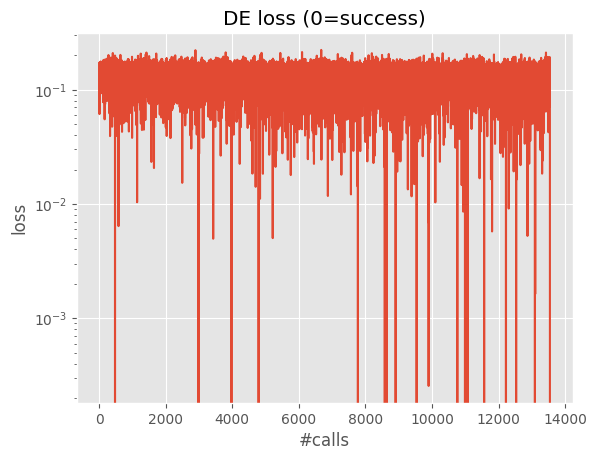

In [ ]:
#!/usr/bin/env python
# coding: utf-8
# Tail‑Patch Query Attack · Scifact toy‑corpus (40 docs)

import random, numpy as np, torch, matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from scipy.optimize import differential_evolution

# ───── hyper‑params ─────
SEED   = 42
K_TOP  = 10                 # 進前 K 就算成功
PATCH  = [509, 510, 511]    # 3 個尾 token
MAXLEN = 512
POP, N_ITER = 15, 300

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEV = "cuda" if torch.cuda.is_available() else "cpu"

# ───── 1. 讀資料 ─────
corpus = load_dataset("BeIR/scifact", "corpus",  split="corpus")
queries= load_dataset("BeIR/scifact", "queries", split="queries")

k = 40                                      # 只取 40 篇做示範
target_text = corpus[0]["text"]             # 指定第 0 篇當 target
corpus_texts = [corpus[i]["text"] for i in range(1, k)]  # 把 target 移除
query_text   = queries[0]["text"]

# ───── 2. BERT ─────
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEV)
VOC  = tok.vocab_size

def enc(x):
    return tok(x, padding="max_length", truncation=True,
               max_length=MAXLEN, return_tensors="pt").to(DEV)

q_enc, t_enc = enc(query_text), enc(target_text)
c_enc        = enc(corpus_texts)

q_ids, q_mask = q_enc["input_ids"][0].clone(), q_enc["attention_mask"][0].clone()

with torch.no_grad():
    t_cls = bert(**t_enc).last_hidden_state[:, 0, :]        # (1,768)
    c_cls = bert(**c_enc).last_hidden_state[:, 0, :]        # (39,768)

# ───── 3. 目標函數：超過第 K 高即可 ─────
trace = []

def patch(ids, vals):
    ids = ids.clone()
    for p, v in zip(PATCH, vals):
        ids[p] = int(v)
    return ids

def cos_row(x, Y):                     # x (1,768) vs Y (n,768) → (n,)
    return torch.nn.functional.cosine_similarity(
             x.expand_as(Y), Y, dim=1)

def objective(x):
    ids = [max(0, min(VOC-1, int(round(v)))) for v in x]
    q_new = patch(q_ids, ids)
    q_mask2 = q_mask.clone(); q_mask2[PATCH] = 1
    with torch.no_grad():
        cls = bert(input_ids=q_new.unsqueeze(0),
                   attention_mask=q_mask2.unsqueeze(0)).last_hidden_state[:, 0, :]
    sims_cor = cos_row(cls, c_cls)                    # (39,)
    kth      = torch.topk(sims_cor, K_TOP).values[-1] # 第 K 名
    sim_qt   = torch.nn.functional.cosine_similarity(cls, t_cls)[0]
    loss = max(0., (kth - sim_qt).item())            # ≤0 ⇒ target 進 Top‑K
    trace.append(loss)
    return loss

# ───── 4. 差分演化 ─────
res = differential_evolution(objective, [(0, VOC-1)]*len(PATCH),
                              maxiter=N_ITER, popsize=POP,
                              strategy="best1bin", seed=SEED, disp=True)
best = [int(round(v)) for v in res.x]

# ───── 5. 重新評分計算排名 ─────
q_adv = patch(q_ids, best); q_mask2 = q_mask.clone(); q_mask2[PATCH] = 1
with torch.no_grad():
    adv_cls = bert(input_ids=q_adv.unsqueeze(0),
                   attention_mask=q_mask2.unsqueeze(0)).last_hidden_state[:, 0, :]

sims_all = torch.cat([cos_row(adv_cls, c_cls),          # 39 docs
                      torch.nn.functional.cosine_similarity(adv_cls, t_cls)])  # target
rank = (sims_all > sims_all[-1]).sum().item() + 1       # 1 = 第一名

print("\nPatched token ids :", best)
print(f"CosSim(advQ, target) = {sims_all[-1]:.4f} | Rank = {rank}")
print("🎯  Success!" if rank <= K_TOP else "✗  Not in Top‑K")

print("\nFull Adv‑Query:\n", tok.decode(q_adv, skip_special_tokens=True))

plt.semilogy(trace); plt.title("DE loss (0=success)"); plt.xlabel("#calls"); plt.ylabel("loss")
plt.show()


In [6]:
#!/usr/bin/env python
# coding: utf-8
# Modest‑scale Tail‑Patch Attack · BEIR/scifact
# 1 000 docs × 100 queries   ‑‑ GPU < 2 GB

import random, numpy as np, torch, tqdm
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from scipy.optimize import differential_evolution

# ───────────── config ─────────────
SEED        = 42
N_DOCS      = 1000          # 抽多少篇文件
N_Q         = 100           # 抽多少條 Query
K_TOP       = 20            # 成功門檻：target 排進前 K_TOP
PATCH_POS   = [509, 510, 511]          # 三個尾 token
POP, ITER   = 20, 120
BATCH       = 32            # corpus encode batch size
# ──────────────────────────────────
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEV = "cuda" if torch.cuda.is_available() else "cpu"

# ───── 1. 讀取子集 ─────
corpus_full  = load_dataset("BeIR/scifact", "corpus",  split="corpus")
queries_full = load_dataset("BeIR/scifact", "queries", split="queries")

docs_idx = random.sample(range(len(corpus_full)),  N_DOCS)
q_idx    = random.sample(range(len(queries_full)), N_Q)

docs      = [corpus_full[i]["text"] for i in docs_idx]
doc_ids   = [corpus_full[i].get("id", corpus_full[i].get("doc_id", str(i)))
             for i in docs_idx]
queries   = [queries_full[i]["text"] for i in q_idx]

target_text = docs[0]           # 先固定第 1 篇為 target（可自行更動）
target_id   = doc_ids[0]
corpus_texts = docs[1:]         # corpus 不含 target

# ───── 2. BERT 初始化 ─────
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEV)
VOC  = tok.vocab_size
def enc(x): return tok(x, padding="max_length", truncation=True,
                       max_length=512, return_tensors="pt")

# ───── 3. corpus CLS 分批 → CPU ─────
with torch.no_grad():
    cls_parts = []
    for i in range(0, len(corpus_texts), BATCH):
        batch = enc(corpus_texts[i:i+BATCH]).to(DEV)
        cls   = bert(**batch).last_hidden_state[:, 0, :].cpu()
        cls_parts.append(cls)
C_CLS = torch.cat(cls_parts)              # (N_DOCS‑1,768) on CPU
t_cls = bert(**enc(target_text).to(DEV)).last_hidden_state[:, 0, :]

# ───── helper ─────
def patch(ids, vals):
    out = ids.clone()
    for p, v in zip(PATCH_POS, vals):
        out[p] = int(v)
    return out

def cos_row(x, Y):
    # x (1,768) GPU / Y (n,768) CPU
    return torch.nn.functional.cosine_similarity(
             x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

succ, tot = 0, 0
delta_all, delta_succ = [], []

for q_txt in tqdm.tqdm(queries, desc="Queries"):
    q_enc = enc(q_txt).to(DEV)
    q_ids = q_enc["input_ids"][0]; q_mask = q_enc["attention_mask"][0]
    with torch.no_grad():
        q_cls = bert(**q_enc).last_hidden_state[:, 0, :]

    # ---- DE objective ----
    def obj(vec):
        ids = [max(0, min(VOC-1, int(round(v)))) for v in vec]
        q_new = patch(q_ids, ids)
        m_ = q_mask.clone(); m_[PATCH_POS] = 1
        with torch.no_grad():
            cls = bert(input_ids=q_new.unsqueeze(0),
                       attention_mask=m_.unsqueeze(0)).last_hidden_state[:, 0, :]
        kth = torch.topk(cos_row(cls, C_CLS), K_TOP).values[-1]
        sim_qt = torch.nn.functional.cosine_similarity(cls, t_cls)[0]
        return max(0., (kth - sim_qt).item())

    res = differential_evolution(obj, [(0, VOC-1)] * len(PATCH_POS),
                                 popsize=POP, maxiter=ITER,
                                 seed=SEED, tol=1e-3, disp=False)
    best = [int(round(v)) for v in res.x]
    q_adv = patch(q_ids, best)
    m_adv = q_mask.clone(); m_adv[PATCH_POS] = 1
    with torch.no_grad():
        adv_cls = bert(input_ids=q_adv.unsqueeze(0),
                       attention_mask=m_adv.unsqueeze(0)).last_hidden_state[:, 0, :]

    # 原始 / 攻擊後與 target 的相似度
    sim_orig = torch.nn.functional.cosine_similarity(q_cls,  t_cls)[0].item()
    sim_adv  = torch.nn.functional.cosine_similarity(adv_cls, t_cls)[0].item()
    delta_all.append(sim_adv - sim_orig)

    # ---- 排名 ----
    sims_all = torch.cat([cos_row(adv_cls.cpu(), C_CLS),
                          torch.nn.functional.cosine_similarity(
                              adv_cls.cpu(), t_cls.cpu())])       # 最後一個是 target
    rank = (sims_all > sims_all[-1]).sum().item() + 1
    if rank <= K_TOP:
        succ += 1
        delta_succ.append(sim_adv - sim_orig)
    tot += 1

# ───── 4. 結果統計 ─────
print(f"\nTarget doc id      : {target_id}")
print(f"Queries evaluated  : {tot}")
print(f"Success@{K_TOP}     : {succ/tot*100:.2f}%")
print(f"Avg ΔCosSim (all)  : {np.mean(delta_all):.4f}")
if delta_succ:
    print(f"Avg ΔCosSim (succ) : {np.mean(delta_succ):.4f}")


Queries: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [3:48:14<00:00, 136.95s/it]


Target doc id      : 912
Queries evaluated  : 100
Success@20     : 52.00%
Avg ΔCosSim (all)  : 0.0232
Avg ΔCosSim (succ) : 0.0203


In [7]:
#!/usr/bin/env python
# coding: utf-8
# Modest‑scale Tail‑Patch Attack · BEIR/scifact
# 1 000 docs × 100 queries   ‑‑ GPU < 2 GB

import random, numpy as np, torch, tqdm
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from scipy.optimize import differential_evolution

# ───────────── config ─────────────
SEED        = 42
N_DOCS      = 1000          # 抽多少篇文件
N_Q         = 100           # 抽多少條 Query
K_TOP       = 1            # 成功門檻：target 排進前 K_TOP
PATCH_POS   = [509, 510, 511]          # 三個尾 token
POP, ITER   = 20, 120
BATCH       = 32            # corpus encode batch size
# ──────────────────────────────────
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEV = "cuda" if torch.cuda.is_available() else "cpu"

# ───── 1. 讀取子集 ─────
corpus_full  = load_dataset("BeIR/scifact", "corpus",  split="corpus")
queries_full = load_dataset("BeIR/scifact", "queries", split="queries")

docs_idx = random.sample(range(len(corpus_full)),  N_DOCS)
q_idx    = random.sample(range(len(queries_full)), N_Q)

docs      = [corpus_full[i]["text"] for i in docs_idx]
doc_ids   = [corpus_full[i].get("id", corpus_full[i].get("doc_id", str(i)))
             for i in docs_idx]
queries   = [queries_full[i]["text"] for i in q_idx]

target_text = docs[0]           # 先固定第 1 篇為 target（可自行更動）
target_id   = doc_ids[0]
corpus_texts = docs[1:]         # corpus 不含 target

# ───── 2. BERT 初始化 ─────
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEV)
VOC  = tok.vocab_size
def enc(x): return tok(x, padding="max_length", truncation=True,
                       max_length=512, return_tensors="pt")

# ───── 3. corpus CLS 分批 → CPU ─────
with torch.no_grad():
    cls_parts = []
    for i in range(0, len(corpus_texts), BATCH):
        batch = enc(corpus_texts[i:i+BATCH]).to(DEV)
        cls   = bert(**batch).last_hidden_state[:, 0, :].cpu()
        cls_parts.append(cls)
C_CLS = torch.cat(cls_parts)              # (N_DOCS‑1,768) on CPU
t_cls = bert(**enc(target_text).to(DEV)).last_hidden_state[:, 0, :]

# ───── helper ─────
def patch(ids, vals):
    out = ids.clone()
    for p, v in zip(PATCH_POS, vals):
        out[p] = int(v)
    return out

def cos_row(x, Y):
    # x (1,768) GPU / Y (n,768) CPU
    return torch.nn.functional.cosine_similarity(
             x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

succ, tot = 0, 0
delta_all, delta_succ = [], []

for q_txt in tqdm.tqdm(queries, desc="Queries"):
    q_enc = enc(q_txt).to(DEV)
    q_ids = q_enc["input_ids"][0]; q_mask = q_enc["attention_mask"][0]
    with torch.no_grad():
        q_cls = bert(**q_enc).last_hidden_state[:, 0, :]

    # ---- DE objective ----
    def obj(vec):
        ids = [max(0, min(VOC-1, int(round(v)))) for v in vec]
        q_new = patch(q_ids, ids)
        m_ = q_mask.clone(); m_[PATCH_POS] = 1
        with torch.no_grad():
            cls = bert(input_ids=q_new.unsqueeze(0),
                       attention_mask=m_.unsqueeze(0)).last_hidden_state[:, 0, :]
        kth = torch.topk(cos_row(cls, C_CLS), K_TOP).values[-1]
        sim_qt = torch.nn.functional.cosine_similarity(cls, t_cls)[0]
        return max(0., (kth - sim_qt).item())

    res = differential_evolution(obj, [(0, VOC-1)] * len(PATCH_POS),
                                 popsize=POP, maxiter=ITER,
                                 seed=SEED, tol=1e-3, disp=False)
    best = [int(round(v)) for v in res.x]
    q_adv = patch(q_ids, best)
    m_adv = q_mask.clone(); m_adv[PATCH_POS] = 1
    with torch.no_grad():
        adv_cls = bert(input_ids=q_adv.unsqueeze(0),
                       attention_mask=m_adv.unsqueeze(0)).last_hidden_state[:, 0, :]

    # 原始 / 攻擊後與 target 的相似度
    sim_orig = torch.nn.functional.cosine_similarity(q_cls,  t_cls)[0].item()
    sim_adv  = torch.nn.functional.cosine_similarity(adv_cls, t_cls)[0].item()
    delta_all.append(sim_adv - sim_orig)

    # ---- 排名 ----
    sims_all = torch.cat([cos_row(adv_cls.cpu(), C_CLS),
                          torch.nn.functional.cosine_similarity(
                              adv_cls.cpu(), t_cls.cpu())])       # 最後一個是 target
    rank = (sims_all > sims_all[-1]).sum().item() + 1
    if rank <= K_TOP:
        succ += 1
        delta_succ.append(sim_adv - sim_orig)
    tot += 1

# ───── 4. 結果統計 ─────
print(f"\nTarget doc id      : {target_id}")
print(f"Queries evaluated  : {tot}")
print(f"Success@{K_TOP}     : {succ/tot*100:.2f}%")
print(f"Avg ΔCosSim (all)  : {np.mean(delta_all):.4f}")
if delta_succ:
    print(f"Avg ΔCosSim (succ) : {np.mean(delta_succ):.4f}")


Queries: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [3:49:20<00:00, 137.60s/it]


Target doc id      : 912
Queries evaluated  : 100
Success@1     : 6.00%
Avg ΔCosSim (all)  : 0.0246
Avg ΔCosSim (succ) : 0.0527


In [8]:
#!/usr/bin/env python
# coding: utf-8
# Modest‑scale Tail‑Patch Attack · BEIR/scifact
# 1 000 docs × 100 queries   ‑‑ GPU < 2 GB

import random, numpy as np, torch, tqdm
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from scipy.optimize import differential_evolution

# ───────────── config ─────────────
SEED        = 42
N_DOCS      = 1000          # 抽多少篇文件
N_Q         = 100           # 抽多少條 Query
K_TOP       = 10            # 成功門檻：target 排進前 K_TOP
PATCH_POS   = [ 511]          # 三個尾 token
POP, ITER   = 20, 120
BATCH       = 32            # corpus encode batch size
# ──────────────────────────────────
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEV = "cuda" if torch.cuda.is_available() else "cpu"

# ───── 1. 讀取子集 ─────
corpus_full  = load_dataset("BeIR/scifact", "corpus",  split="corpus")
queries_full = load_dataset("BeIR/scifact", "queries", split="queries")

docs_idx = random.sample(range(len(corpus_full)),  N_DOCS)
q_idx    = random.sample(range(len(queries_full)), N_Q)

docs      = [corpus_full[i]["text"] for i in docs_idx]
doc_ids   = [corpus_full[i].get("id", corpus_full[i].get("doc_id", str(i)))
             for i in docs_idx]
queries   = [queries_full[i]["text"] for i in q_idx]

target_text = docs[0]           # 先固定第 1 篇為 target（可自行更動）
target_id   = doc_ids[0]
corpus_texts = docs[1:]         # corpus 不含 target

# ───── 2. BERT 初始化 ─────
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEV)
VOC  = tok.vocab_size
def enc(x): return tok(x, padding="max_length", truncation=True,
                       max_length=512, return_tensors="pt")

# ───── 3. corpus CLS 分批 → CPU ─────
with torch.no_grad():
    cls_parts = []
    for i in range(0, len(corpus_texts), BATCH):
        batch = enc(corpus_texts[i:i+BATCH]).to(DEV)
        cls   = bert(**batch).last_hidden_state[:, 0, :].cpu()
        cls_parts.append(cls)
C_CLS = torch.cat(cls_parts)              # (N_DOCS‑1,768) on CPU
t_cls = bert(**enc(target_text).to(DEV)).last_hidden_state[:, 0, :]

# ───── helper ─────
def patch(ids, vals):
    out = ids.clone()
    for p, v in zip(PATCH_POS, vals):
        out[p] = int(v)
    return out

def cos_row(x, Y):
    # x (1,768) GPU / Y (n,768) CPU
    return torch.nn.functional.cosine_similarity(
             x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

succ, tot = 0, 0
delta_all, delta_succ = [], []

for q_txt in tqdm.tqdm(queries, desc="Queries"):
    q_enc = enc(q_txt).to(DEV)
    q_ids = q_enc["input_ids"][0]; q_mask = q_enc["attention_mask"][0]
    with torch.no_grad():
        q_cls = bert(**q_enc).last_hidden_state[:, 0, :]

    # ---- DE objective ----
    def obj(vec):
        ids = [max(0, min(VOC-1, int(round(v)))) for v in vec]
        q_new = patch(q_ids, ids)
        m_ = q_mask.clone(); m_[PATCH_POS] = 1
        with torch.no_grad():
            cls = bert(input_ids=q_new.unsqueeze(0),
                       attention_mask=m_.unsqueeze(0)).last_hidden_state[:, 0, :]
        kth = torch.topk(cos_row(cls, C_CLS), K_TOP).values[-1]
        sim_qt = torch.nn.functional.cosine_similarity(cls, t_cls)[0]
        return max(0., (kth - sim_qt).item())

    res = differential_evolution(obj, [(0, VOC-1)] * len(PATCH_POS),
                                 popsize=POP, maxiter=ITER,
                                 seed=SEED, tol=1e-3, disp=False)
    best = [int(round(v)) for v in res.x]
    q_adv = patch(q_ids, best)
    m_adv = q_mask.clone(); m_adv[PATCH_POS] = 1
    with torch.no_grad():
        adv_cls = bert(input_ids=q_adv.unsqueeze(0),
                       attention_mask=m_adv.unsqueeze(0)).last_hidden_state[:, 0, :]

    # 原始 / 攻擊後與 target 的相似度
    sim_orig = torch.nn.functional.cosine_similarity(q_cls,  t_cls)[0].item()
    sim_adv  = torch.nn.functional.cosine_similarity(adv_cls, t_cls)[0].item()
    delta_all.append(sim_adv - sim_orig)

    # ---- 排名 ----
    sims_all = torch.cat([cos_row(adv_cls.cpu(), C_CLS),
                          torch.nn.functional.cosine_similarity(
                              adv_cls.cpu(), t_cls.cpu())])       # 最後一個是 target
    rank = (sims_all > sims_all[-1]).sum().item() + 1
    if rank <= K_TOP:
        succ += 1
        delta_succ.append(sim_adv - sim_orig)
    tot += 1

# ───── 4. 結果統計 ─────
print(f"\nTarget doc id      : {target_id}")
print(f"Queries evaluated  : {tot}")
print(f"Success@{K_TOP}     : {succ/tot*100:.2f}%")
print(f"Avg ΔCosSim (all)  : {np.mean(delta_all):.4f}")
if delta_succ:
    print(f"Avg ΔCosSim (succ) : {np.mean(delta_succ):.4f}")


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [53:35<00:00, 32.16s/it]


Target doc id      : 912
Queries evaluated  : 100
Success@10     : 3.00%
Avg ΔCosSim (all)  : 0.0045
Avg ΔCosSim (succ) : 0.0152


In [9]:
#!/usr/bin/env python
# coding: utf-8
# Modest‑scale Tail‑Patch Attack · BEIR/scifact
# 1 000 docs × 100 queries   ‑‑ GPU < 2 GB

import random, numpy as np, torch, tqdm
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from scipy.optimize import differential_evolution

# ───────────── config ─────────────
SEED        = 42
N_DOCS      = 1000          # 抽多少篇文件
N_Q         = 100           # 抽多少條 Query
K_TOP       = 1          # 成功門檻：target 排進前 K_TOP
PATCH_POS   = [507,508,509,510, 511]          # 三個尾 token
POP, ITER   = 20, 120
BATCH       = 32            # corpus encode batch size
# ──────────────────────────────────
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEV = "cuda" if torch.cuda.is_available() else "cpu"

# ───── 1. 讀取子集 ─────
corpus_full  = load_dataset("BeIR/scifact", "corpus",  split="corpus")
queries_full = load_dataset("BeIR/scifact", "queries", split="queries")

docs_idx = random.sample(range(len(corpus_full)),  N_DOCS)
q_idx    = random.sample(range(len(queries_full)), N_Q)

docs      = [corpus_full[i]["text"] for i in docs_idx]
doc_ids   = [corpus_full[i].get("id", corpus_full[i].get("doc_id", str(i)))
             for i in docs_idx]
queries   = [queries_full[i]["text"] for i in q_idx]

target_text = docs[0]           # 先固定第 1 篇為 target（可自行更動）
target_id   = doc_ids[0]
corpus_texts = docs[1:]         # corpus 不含 target

# ───── 2. BERT 初始化 ─────
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEV)
VOC  = tok.vocab_size
def enc(x): return tok(x, padding="max_length", truncation=True,
                       max_length=512, return_tensors="pt")

# ───── 3. corpus CLS 分批 → CPU ─────
with torch.no_grad():
    cls_parts = []
    for i in range(0, len(corpus_texts), BATCH):
        batch = enc(corpus_texts[i:i+BATCH]).to(DEV)
        cls   = bert(**batch).last_hidden_state[:, 0, :].cpu()
        cls_parts.append(cls)
C_CLS = torch.cat(cls_parts)              # (N_DOCS‑1,768) on CPU
t_cls = bert(**enc(target_text).to(DEV)).last_hidden_state[:, 0, :]

# ───── helper ─────
def patch(ids, vals):
    out = ids.clone()
    for p, v in zip(PATCH_POS, vals):
        out[p] = int(v)
    return out

def cos_row(x, Y):
    # x (1,768) GPU / Y (n,768) CPU
    return torch.nn.functional.cosine_similarity(
             x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

succ, tot = 0, 0
delta_all, delta_succ = [], []

for q_txt in tqdm.tqdm(queries, desc="Queries"):
    q_enc = enc(q_txt).to(DEV)
    q_ids = q_enc["input_ids"][0]; q_mask = q_enc["attention_mask"][0]
    with torch.no_grad():
        q_cls = bert(**q_enc).last_hidden_state[:, 0, :]

    # ---- DE objective ----
    def obj(vec):
        ids = [max(0, min(VOC-1, int(round(v)))) for v in vec]
        q_new = patch(q_ids, ids)
        m_ = q_mask.clone(); m_[PATCH_POS] = 1
        with torch.no_grad():
            cls = bert(input_ids=q_new.unsqueeze(0),
                       attention_mask=m_.unsqueeze(0)).last_hidden_state[:, 0, :]
        kth = torch.topk(cos_row(cls, C_CLS), K_TOP).values[-1]
        sim_qt = torch.nn.functional.cosine_similarity(cls, t_cls)[0]
        return max(0., (kth - sim_qt).item())

    res = differential_evolution(obj, [(0, VOC-1)] * len(PATCH_POS),
                                 popsize=POP, maxiter=ITER,
                                 seed=SEED, tol=1e-3, disp=False)
    best = [int(round(v)) for v in res.x]
    q_adv = patch(q_ids, best)
    m_adv = q_mask.clone(); m_adv[PATCH_POS] = 1
    with torch.no_grad():
        adv_cls = bert(input_ids=q_adv.unsqueeze(0),
                       attention_mask=m_adv.unsqueeze(0)).last_hidden_state[:, 0, :]

    # 原始 / 攻擊後與 target 的相似度
    sim_orig = torch.nn.functional.cosine_similarity(q_cls,  t_cls)[0].item()
    sim_adv  = torch.nn.functional.cosine_similarity(adv_cls, t_cls)[0].item()
    delta_all.append(sim_adv - sim_orig)

    # ---- 排名 ----
    sims_all = torch.cat([cos_row(adv_cls.cpu(), C_CLS),
                          torch.nn.functional.cosine_similarity(
                              adv_cls.cpu(), t_cls.cpu())])       # 最後一個是 target
    rank = (sims_all > sims_all[-1]).sum().item() + 1
    if rank <= K_TOP:
        succ += 1
        delta_succ.append(sim_adv - sim_orig)
    tot += 1

# ───── 4. 結果統計 ─────
print(f"\nTarget doc id      : {target_id}")
print(f"Queries evaluated  : {tot}")
print(f"Success@{K_TOP}     : {succ/tot*100:.2f}%")
print(f"Avg ΔCosSim (all)  : {np.mean(delta_all):.4f}")
if delta_succ:
    print(f"Avg ΔCosSim (succ) : {np.mean(delta_succ):.4f}")


Queries: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [6:25:04<00:00, 231.04s/it]


Target doc id      : 912
Queries evaluated  : 100
Success@1     : 6.00%
Avg ΔCosSim (all)  : 0.0371
Avg ΔCosSim (succ) : 0.0185


In [10]:
#!/usr/bin/env python
# coding: utf-8
# Modest‑scale Tail‑Patch Attack · BEIR/scifact
# 1 000 docs × 100 queries   ‑‑ GPU < 2 GB

import random, numpy as np, torch, tqdm
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from scipy.optimize import differential_evolution

# ───────────── config ─────────────
SEED        = 42
N_DOCS      = 1000          # 抽多少篇文件
N_Q         = 100           # 抽多少條 Query
K_TOP       = 1          # 成功門檻：target 排進前 K_TOP
PATCH_POS   = [502,503,504,505,506,507,508,509,510, 511]          # 三個尾 token
POP, ITER   = 20, 120
BATCH       = 32            # corpus encode batch size
# ──────────────────────────────────
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEV = "cuda" if torch.cuda.is_available() else "cpu"

# ───── 1. 讀取子集 ─────
corpus_full  = load_dataset("BeIR/scifact", "corpus",  split="corpus")
queries_full = load_dataset("BeIR/scifact", "queries", split="queries")

docs_idx = random.sample(range(len(corpus_full)),  N_DOCS)
q_idx    = random.sample(range(len(queries_full)), N_Q)

docs      = [corpus_full[i]["text"] for i in docs_idx]
doc_ids   = [corpus_full[i].get("id", corpus_full[i].get("doc_id", str(i)))
             for i in docs_idx]
queries   = [queries_full[i]["text"] for i in q_idx]

target_text = docs[0]           # 先固定第 1 篇為 target（可自行更動）
target_id   = doc_ids[0]
corpus_texts = docs[1:]         # corpus 不含 target

# ───── 2. BERT 初始化 ─────
tok  = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").eval().to(DEV)
VOC  = tok.vocab_size
def enc(x): return tok(x, padding="max_length", truncation=True,
                       max_length=512, return_tensors="pt")

# ───── 3. corpus CLS 分批 → CPU ─────
with torch.no_grad():
    cls_parts = []
    for i in range(0, len(corpus_texts), BATCH):
        batch = enc(corpus_texts[i:i+BATCH]).to(DEV)
        cls   = bert(**batch).last_hidden_state[:, 0, :].cpu()
        cls_parts.append(cls)
C_CLS = torch.cat(cls_parts)              # (N_DOCS‑1,768) on CPU
t_cls = bert(**enc(target_text).to(DEV)).last_hidden_state[:, 0, :]

# ───── helper ─────
def patch(ids, vals):
    out = ids.clone()
    for p, v in zip(PATCH_POS, vals):
        out[p] = int(v)
    return out

def cos_row(x, Y):
    # x (1,768) GPU / Y (n,768) CPU
    return torch.nn.functional.cosine_similarity(
             x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

succ, tot = 0, 0
delta_all, delta_succ = [], []

for q_txt in tqdm.tqdm(queries, desc="Queries"):
    q_enc = enc(q_txt).to(DEV)
    q_ids = q_enc["input_ids"][0]; q_mask = q_enc["attention_mask"][0]
    with torch.no_grad():
        q_cls = bert(**q_enc).last_hidden_state[:, 0, :]

    # ---- DE objective ----
    def obj(vec):
        ids = [max(0, min(VOC-1, int(round(v)))) for v in vec]
        q_new = patch(q_ids, ids)
        m_ = q_mask.clone(); m_[PATCH_POS] = 1
        with torch.no_grad():
            cls = bert(input_ids=q_new.unsqueeze(0),
                       attention_mask=m_.unsqueeze(0)).last_hidden_state[:, 0, :]
        kth = torch.topk(cos_row(cls, C_CLS), K_TOP).values[-1]
        sim_qt = torch.nn.functional.cosine_similarity(cls, t_cls)[0]
        return max(0., (kth - sim_qt).item())

    res = differential_evolution(obj, [(0, VOC-1)] * len(PATCH_POS),
                                 popsize=POP, maxiter=ITER,
                                 seed=SEED, tol=1e-3, disp=False)
    best = [int(round(v)) for v in res.x]
    q_adv = patch(q_ids, best)
    m_adv = q_mask.clone(); m_adv[PATCH_POS] = 1
    with torch.no_grad():
        adv_cls = bert(input_ids=q_adv.unsqueeze(0),
                       attention_mask=m_adv.unsqueeze(0)).last_hidden_state[:, 0, :]

    # 原始 / 攻擊後與 target 的相似度
    sim_orig = torch.nn.functional.cosine_similarity(q_cls,  t_cls)[0].item()
    sim_adv  = torch.nn.functional.cosine_similarity(adv_cls, t_cls)[0].item()
    delta_all.append(sim_adv - sim_orig)

    # ---- 排名 ----
    sims_all = torch.cat([cos_row(adv_cls.cpu(), C_CLS),
                          torch.nn.functional.cosine_similarity(
                              adv_cls.cpu(), t_cls.cpu())])       # 最後一個是 target
    rank = (sims_all > sims_all[-1]).sum().item() + 1
    if rank <= K_TOP:
        succ += 1
        delta_succ.append(sim_adv - sim_orig)
    tot += 1

# ───── 4. 結果統計 ─────
print(f"\nTarget doc id      : {target_id}")
print(f"Queries evaluated  : {tot}")
print(f"Success@{K_TOP}     : {succ/tot*100:.2f}%")
print(f"Avg ΔCosSim (all)  : {np.mean(delta_all):.4f}")
if delta_succ:
    print(f"Avg ΔCosSim (succ) : {np.mean(delta_succ):.4f}")


Queries: 100%|████████████████████████████████████████████████████████████████████| 100/100 [12:57:49<00:00, 466.70s/it]


Target doc id      : 912
Queries evaluated  : 100
Success@1     : 2.00%
Avg ΔCosSim (all)  : 0.0474
Avg ΔCosSim (succ) : 0.0965


In [11]:
#!/usr/bin/env python
# tail_patch_fixedIter_baselines.py
# 比較 none / random / freq / de (固定 120 代)
# Author: <your-name>  2025-04-27
import random, time, math, collections
import numpy as np, pandas as pd, torch, tqdm, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

# ────────────── CONFIG ──────────────
SEED=42; N_DOCS=1000; N_Q=100
BUDGETS=[0,1,2,3,4,5]
METHODS=["none","random","freq","de"]
K_LIST=[1,10,20]; K_NDCG=20
POP=20; MAXITER=150; BATCH=32
DEV="cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ─────────── 0. 下載資料集 ───────────
corpus=load_dataset("BeIR/scifact","corpus", split="corpus")
queries=load_dataset("BeIR/scifact","queries",split="queries")
D_ID=random.sample(range(len(corpus)),N_DOCS)
Q_ID=random.sample(range(len(queries)),N_Q)
DOCS=[corpus[i]["text"] for i in D_ID]
QS  =[queries[i]["text"] for i in Q_ID]

# ─────────── 1. BERT 初始化 ───────────
tok=BertTokenizer.from_pretrained("bert-base-uncased")
bert=BertModel.from_pretrained("bert-base-uncased").eval().to(DEV)
VOC=tok.vocab_size
def enc(txt): return tok(txt,padding="max_length",truncation=True,
                         max_length=512,return_tensors="pt").to(DEV)

# ─────────── 2. 編碼 corpus CLS ───────────
print("Encoding corpus CLS…")
with torch.no_grad():
    parts=[]
    for i in tqdm.tqdm(range(0,N_DOCS,BATCH)):
        parts.append(bert(**enc(DOCS[i:i+BATCH])).last_hidden_state[:,0,:].cpu())
C_CLS=torch.cat(parts)                  # (N_DOCS,768) CPU

# ─────────── 3. 計算最常見 token (freq) ───────────
print("Counting token frequency for 'freq' baseline…")
cnt=collections.Counter()
for txt in DOCS:
    ids=tok(txt,add_special_tokens=False)["input_ids"]; cnt.update(ids)
most_common_token=cnt.most_common(1)[0][0]  # int token id
print(f"Most frequent token id = {most_common_token}")

# ─────────── 4. Helper ───────────
MAX_L=max(BUDGETS); PATCH_POS=list(range(502,502+MAX_L))
def cos_row(x,Ycpu):
    return torch.nn.functional.cosine_similarity(x.cpu().expand_as(Ycpu),Ycpu,dim=1)
def dcg(rank): return 1/math.log2(rank+1)

# ─────────── 5. 主迴圈 ───────────
records=[]
for L in BUDGETS:
    pos=PATCH_POS[:L]
    for method in METHODS:
        if L==0 and method!="none": continue   # 沒 token 時只有 none
        print(f"\n== Budget {L}  |  Method {method} ==")
        for q_txt in tqdm.tqdm(QS,desc="Queries"):
            tgt_idx=random.randrange(N_DOCS)
            tgt_cls=C_CLS[tgt_idx:tgt_idx+1].to(DEV)
            cp_mask=[i for i in range(N_DOCS) if i!=tgt_idx]
            CP=C_CLS[cp_mask]

            q_enc=enc(q_txt); ids=q_enc["input_ids"][0]; mask=q_enc["attention_mask"][0]
            with torch.no_grad():
                q_orig_cls=bert(**q_enc).last_hidden_state[:,0,:]

            # baseline ranks
            sims_base=torch.cat([cos_row(q_orig_cls,CP),
                                 torch.nn.functional.cosine_similarity(
                                     q_orig_cls.cpu(),tgt_cls.cpu())])
            rank_b=(sims_base>sims_base[-1]).sum().item()+1
            mrr_b=1/rank_b; ndcg_b=dcg(rank_b) if rank_b<=K_NDCG else 0.0

            # ---------- 生成補丁 ----------
            if method=="none" or L==0:
                adv_cls=q_orig_cls
            elif method=="random":
                rand_ids=[random.randrange(VOC) for _ in range(L)]
                new_ids=ids.clone()
                for p,v in zip(pos,rand_ids): new_ids[p]=v
                new_mask=mask.clone(); new_mask[pos]=1
                with torch.no_grad():
                    adv_cls=bert(input_ids=new_ids.unsqueeze(0),
                                 attention_mask=new_mask.unsqueeze(0)).last_hidden_state[:,0,:]
            elif method=="freq":
                new_ids=ids.clone()
                for p in pos: new_ids[p]=most_common_token
                new_mask=mask.clone(); new_mask[pos]=1
                with torch.no_grad():
                    adv_cls=bert(input_ids=new_ids.unsqueeze(0),
                                 attention_mask=new_mask.unsqueeze(0)).last_hidden_state[:,0,:]
            elif method=="de":
                def obj(vec,k_top=K_LIST[-1]):
                    ids_int=[max(0,min(VOC-1,int(round(v)))) for v in vec]
                    patched=ids.clone()
                    for p,v in zip(pos,ids_int): patched[p]=v
                    m_=mask.clone(); m_[pos]=1
                    with torch.no_grad():
                        cls=bert(input_ids=patched.unsqueeze(0),
                                 attention_mask=m_.unsqueeze(0)).last_hidden_state[:,0,:]
                    kth=torch.topk(cos_row(cls,CP),k_top).values[-1]
                    sim=torch.nn.functional.cosine_similarity(cls,tgt_cls)[0]
                    return max(0.,(kth-sim).item())
                res=differential_evolution(obj,[(0,VOC-1)]*L,
                        popsize=POP,maxiter=MAXITER,seed=SEED,tol=1e-3,polish=False)
                best=[int(round(v)) for v in res.x]
                new_ids=ids.clone()
                for p,v in zip(pos,best): new_ids[p]=v
                new_mask=mask.clone(); new_mask[pos]=1
                with torch.no_grad():
                    adv_cls=bert(input_ids=new_ids.unsqueeze(0),
                                 attention_mask=new_mask.unsqueeze(0)).last_hidden_state[:,0,:]

            # ---------- 評估 ----------
            sims_att=torch.cat([cos_row(adv_cls.cpu(),CP),
                                torch.nn.functional.cosine_similarity(
                                    adv_cls.cpu(),tgt_cls.cpu())])
            rank_a=(sims_att>sims_att[-1]).sum().item()+1
            mrr_a=1/rank_a; ndcg_a=dcg(rank_a) if rank_a<=K_NDCG else 0.0
            d_mrr=mrr_a-mrr_b; d_ndcg=ndcg_a-ndcg_b
            d_cos=(torch.nn.functional.cosine_similarity(adv_cls,tgt_cls)[0]-
                   torch.nn.functional.cosine_similarity(q_orig_cls,tgt_cls)[0]).item()

            for k in K_LIST:
                records.append(dict(budget=L,method=method,top_k=k,
                                    success=int(rank_a<=k),
                                    delta_mrr=d_mrr,delta_ndcg=d_ndcg,delta_cos=d_cos))

# ─────────── 6. 存檔 / 摘要 ───────────
df=pd.DataFrame(records)
df.to_csv("records_fixedIter.csv",index=False)

summary=(df.groupby(["budget","method"])
            .agg(**{f"Success@{k}":("success",
                  lambda x,kk=k: x[df["top_k"]==kk].mean()*100)
                  for k in K_LIST},
                  ΔMRR=("delta_mrr","mean"),
                  ΔnDCG=("delta_ndcg","mean"),
                  ΔCosSim=("delta_cos","mean"))
            .reset_index())
summary.to_csv("summary_fixedIter.csv",index=False)
print("\n=== Fixed-Iter Summary ===\n",summary.head())

print("\n✅  fixedIter 版完成，CSV 皆已輸出。")


Encoding corpus CLS…


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  2.00it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


Counting token frequency for 'freq' baseline…
Most frequent token id = 1012

== Budget 0  |  Method none ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.14it/s]



== Budget 1  |  Method none ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.92it/s]



== Budget 1  |  Method random ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.31it/s]



== Budget 1  |  Method freq ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.51it/s]



== Budget 1  |  Method de ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [46:31<00:00, 27.91s/it]



== Budget 2  |  Method none ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.17it/s]



== Budget 2  |  Method random ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.08it/s]



== Budget 2  |  Method freq ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.21it/s]



== Budget 2  |  Method de ==


Queries: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [3:04:36<00:00, 110.76s/it]



== Budget 3  |  Method none ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.69it/s]



== Budget 3  |  Method random ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.01it/s]



== Budget 3  |  Method freq ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.88it/s]



== Budget 3  |  Method de ==


Queries: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [4:30:13<00:00, 162.14s/it]



== Budget 4  |  Method none ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.03it/s]



== Budget 4  |  Method random ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.91it/s]



== Budget 4  |  Method freq ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.55it/s]



== Budget 4  |  Method de ==


Queries: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [6:14:42<00:00, 224.83s/it]



== Budget 5  |  Method none ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.50it/s]



== Budget 5  |  Method random ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.88it/s]



== Budget 5  |  Method freq ==


Queries: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.91it/s]



== Budget 5  |  Method de ==


Queries: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [7:42:24<00:00, 277.45s/it]


=== Fixed-Iter Summary ===
    budget  method  Success@1  Success@10  Success@20      ΔMRR     ΔnDCG  \
0       0    none        0.0         2.0         2.0  0.000000  0.000000   
1       1      de        0.0         5.0        21.0  0.023749  0.055551   
2       1    freq        0.0         0.0         1.0 -0.001993 -0.005791   
3       1    none        1.0         2.0         3.0  0.000000  0.000000   
4       1  random        0.0         0.0         0.0  0.000250 -0.002277   

    ΔCosSim  
0  0.000000  
1 -0.023236  
2  0.012553  
3  0.000000  
4 -0.032647  

✅  fixedIter 版完成，CSV 皆已輸出。
